# Bibliotecas

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler

import keras.backend as K
from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.layers import Dropout
from keras.utils.vis_utils import plot_model
from keras.utils.np_utils import  to_categorical
from keras.callbacks import ModelCheckpoint

from quickda.explore_data import *

# Ignorar Avisos desnecessários
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

In [ ]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


# Funções Auxiliares

In [ ]:
# Funções Auxiliares
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training Accuracy')
    plt.plot(x, val_acc, 'r', label='Validation Accuracy')
    plt.title('Training and validation Accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    
def min_max(serie):
    min = serie.min()
    max = serie.max()
    
    return serie.apply(lambda x: (x-min)/(max-min))

class ModelCheckpoint_tweaked(tf.keras.callbacks.ModelCheckpoint):
    def __init__(self,
                   filepath,
                   monitor='val_loss',
                   verbose=0,
                   save_best_only=False,
                   save_weights_only=False,
                   mode='auto',
                   save_freq='epoch',
                   options=None,
                   **kwargs):
        
        #Change tf_utils source package.
        from tensorflow.python.keras.utils import tf_utils
        
        super(ModelCheckpoint_tweaked, self).__init__(filepath,
                   monitor,
                   verbose,
                   save_best_only,
                   save_weights_only,
                   mode,
                   save_freq,
                   options,
                   **kwargs)
        
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
        
    return f1_val

# Carregando e Analisando os dados

In [ ]:
X = pd.read_csv("./data/DatasetExercicio5.1.csv", sep=';')
y = pd.read_csv("./data/Classes-Exercicio5.1.csv", sep=';')

In [ ]:
print(f"Número de variáveis = {len(X.columns)}")

Número de variáveis = 17


## Amostra dos Dados

In [ ]:
X.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,-0.732337,-0.460087,0.410588,1.387655,1.549960,-0.309028,-0.119034,-1.710895,-2.103701,0.270298,-0.951528,-1.738395,2.242746,-0.062398,3.600965,0.506660,-0.351065
1,-1.697668,-3.658057,-0.067462,-0.307627,-3.257361,3.018813,0.506056,-1.943546,-0.781291,-1.054938,-0.903841,-0.971778,0.725666,-0.288371,2.136540,-0.172262,-3.538182
2,-0.009419,-2.079725,0.695339,1.395909,-1.152059,-0.149841,-1.748309,0.663311,0.243399,-0.468567,-1.793045,0.313092,0.156787,0.646463,0.872121,-0.876460,-0.159286
3,-0.955029,2.413873,-0.239355,0.296029,0.785301,-2.146341,1.792001,0.023154,-0.379947,1.025835,0.083103,1.352882,0.061962,0.043511,-1.387151,1.786397,0.813789
4,2.282446,0.764661,0.385960,-3.203398,0.165334,2.816127,-0.592895,-0.460681,1.613249,-0.383905,1.345218,0.173645,1.299997,-0.356091,-2.358184,0.142573,-1.503465


In [ ]:
y.head()

,0
0,7
1,4
2,6
3,5
4,1


In [ ]:
explore(X)

,dtypes,count,null_sum,null_pct,nunique,min,25%,50%,75%,max,mean,median,std,skew
0,float64,30000,0,0.0,30000,-3.915,-0.661,0.012,0.684,4.467,0.012,0.012,0.998,0.002
1,float64,30000,0,0.0,30000,-7.450,-0.816,0.426,1.588,7.233,0.365,0.426,1.809,-0.158
2,float64,30000,0,0.0,30000,-3.900,-0.691,-0.016,0.661,4.236,-0.013,-0.016,0.999,0.029
3,float64,30000,0,0.0,30000,-8.324,-1.567,-0.416,0.773,6.928,-0.388,-0.416,1.736,0.046
4,float64,30000,0,0.0,30000,-7.871,-1.470,-0.260,1.013,8.052,-0.241,-0.260,1.828,-0.028
5,float64,30000,0,0.0,30000,-13.595,-1.481,0.058,1.671,11.448,0.095,0.058,2.607,0.027
6,float64,30000,0,0.0,30000,-4.059,-0.671,0.003,0.672,4.410,-0.000,0.003,1.001,-0.007
7,float64,30000,0,0.0,30000,-9.170,-1.532,-0.346,0.946,7.577,-0.258,-0.346,1.849,0.181
8,float64,30000,0,0.0,30000,-8.246,-1.428,-0.116,1.151,7.924,-0.137,-0.116,1.885,-0.003
9,float64,30000,0,0.0,30000,-3.691,-0.675,0.014,0.684,4.404,0.005,0.014,1.005,-0.018


## Distribuição das respostas

### Abaixo verificamos que a distribuição das respostas é perfeita.

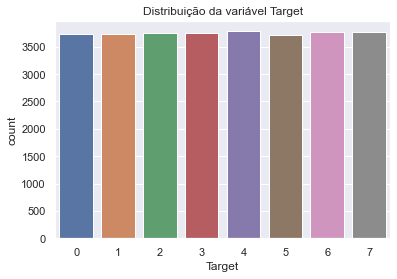

In [ ]:
sns.countplot(y['0'])
plt.title('Distribuição da variável Target')
plt.xlabel('Target')
plt.xticks()
plt.show()

## Análise de correlação

### Apesar de uma correlação forte entre algumas variáveis não conseguimos nenhuma melhora no modelo ao retirar algumas delas.

<AxesSubplot:>

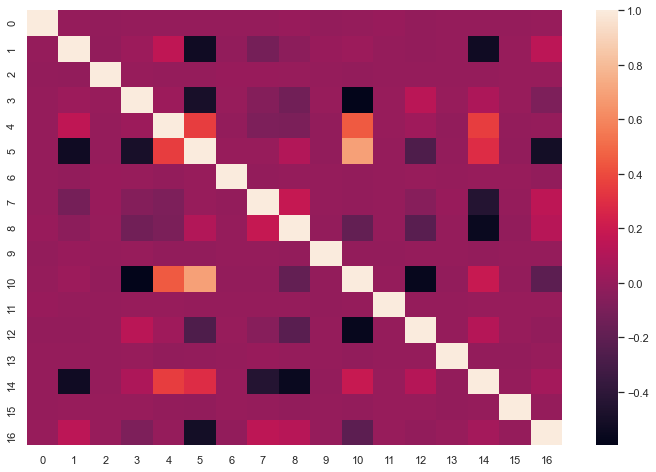

In [ ]:
fig = plt.figure(figsize=(12,8))
sns.heatmap(X.corr())
#corr.style.background_gradient(cmap='coolwarm').set_precision(2)

In [ ]:
scaler = StandardScaler()
X = scaler.fit_transform(X)
num_features = X.shape[1]
X.shape

(30000, 17)

In [ ]:
y = y.to_numpy()
num_classes = len(np.unique(y)) # y.shape[1]
y = to_categorical(y, num_classes)
print(num_classes)
y.shape

8


(30000, 8)

In [ ]:
y[:5]

array([[0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X_train.shape

(24000, 17)

# Modelo de MLP

In [ ]:
## Criando o modelo
model = Sequential()
model.add(Dense(68, input_dim=num_features, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(132, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 68)                1224      
_________________________________________________________________
dropout_2 (Dropout)          (None, 68)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 132)               9108      
_________________________________________________________________
dropout_3 (Dropout)          (None, 132)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 1064      
Total params: 11,396
Trainable params: 11,396
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
#plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
%%time
checkpointer = ModelCheckpoint(filepath='./modelo_mlp_ex5_2.hdf5', verbose=1, save_best_only=True, monitor='val_accuracy')

history = model.fit(X_train, y_train, validation_split=0.2, epochs=500, batch_size=256, verbose=1, callbacks=[checkpointer])

Epoch 1/500
60/75 [=======================>......] - ETA: 0s - loss: 1.9274 - accuracy: 0.2639
Epoch 00001: val_accuracy improved from -inf to 0.37854, saving model to .\modelo_mlp_ex5_2.hdf5
75/75 [==============================] - 0s 6ms/step - loss: 1.9005 - accuracy: 0.2792 - val_loss: 1.7088 - val_accuracy: 0.3785
Epoch 2/500
63/75 [========================>.....] - ETA: 0s - loss: 1.6717 - accuracy: 0.3909
Epoch 00002: val_accuracy improved from 0.37854 to 0.45708, saving model to .\modelo_mlp_ex5_2.hdf5
75/75 [==============================] - 0s 3ms/step - loss: 1.6600 - accuracy: 0.3942 - val_loss: 1.5330 - val_accuracy: 0.4571
Epoch 3/500
58/75 [======================>.......] - ETA: 0s - loss: 1.5452 - accuracy: 0.4498
Epoch 00003: val_accuracy improved from 0.45708 to 0.51896, saving model to .\modelo_mlp_ex5_2.hdf5
75/75 [==============================] - 0s 3ms/step - loss: 1.5385 - accuracy: 0.4511 - val_loss: 1.4140 - val_accuracy: 0.5190
Epoch 4/500
56/75 [============

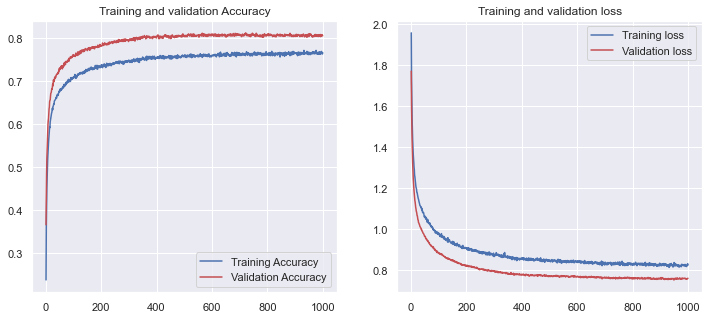

In [ ]:
plot_history(history)

In [ ]:
plot_history(history)

## Apresentando a Acurácia final do Treino, carregando o melhor modelo salvo e apresentando a Acurácia do Teste

In [ ]:
scores = model.evaluate(X_train, y_train)
print()
print(f"Acuracia do Treino: {round(scores[1]*100,2)}%")

750/750 [==============================] - 1s 2ms/step - loss: 0.6606 - accuracy: 0.8335

Acuracia do Treino: 83.35%


In [ ]:
model = load_model("./modelo_mlp_ex5_2.hdf5")

In [ ]:
scores = model.evaluate(X_test, y_test)
print()
print(f"Acuracia do Teste: {round(scores[1]*100,2)}%")

188/188 [==============================] - 0s 2ms/step - loss: 0.7831 - accuracy: 0.8018

Acuracia do Teste: 80.18%


## Acurácia final acima de 80% na Base de Treino.